# Auto Grading By Using KNearestNeighborClassifier

The data that is used in this project is obtained from https://www.kaggle.com/c/asap-aes.
However, it is changed easier implemenentation.

### Import packages

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import cohen_kappa_score

from scipy import sparse

In [2]:
def StemmingWordList(arrayList):
    ps = nltk.PorterStemmer()
    newList = [ps.stem(word) for word in arrayList]
    return ''.join(newList)

svd = TruncatedSVD(n_iter=10, n_components=100)
tfidf = TfidfVectorizer(min_df = 0.1, max_df=0.85, stop_words='english', max_features=5000)

### Import data

In [3]:
train = pd.read_excel('./Data/training_set_rel3_set1.xlsx')
test = pd.read_excel('./Data/valid_set_set1.xlsx')
train.set_index('ID')
test.set_index('essay_id')
y_train = train['Score']
y_test = test['Score']

## Creating 2 addtional features
### "Number of words" and "Number of sentences" improve the accuracy

In [4]:
train_numberOfSentences = train['Essay Content'].apply(lambda x: len(x.split('.')))
train_numberOfWords = train['Essay Content'].apply(lambda x: len(x.split()))

test_numberOfSentences = test['essay'].apply(lambda x: len(x.split('.')))
test_numberOfWords = test['essay'].apply(lambda x: len(x.split()))

### The relationship between number_of_words and number_of_sentences and score

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

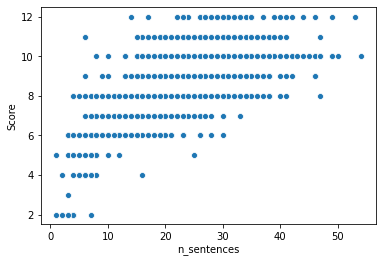

In [25]:
train['n_sentences'] = train_numberOfSentences
train['n_words'] = train_numberOfWords
sns.scatterplot('n_sentences', 'Score', data=train)

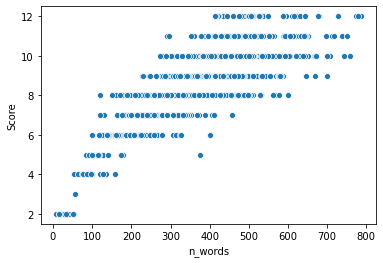

In [26]:
sns.scatterplot('n_words', 'Score', data=train)

In [5]:
content = train['Essay Content']
content = content.apply(lambda x: re.sub('^[a-zA-Z]', ' ', x))
content = content.apply(lambda x: StemmingWordList(x))

In [6]:
x_train = tfidf.fit_transform(content)

In [7]:
x_train = sparse.hstack((x_train, train_numberOfSentences[:,None]))
x_train = sparse.hstack((x_train, train_numberOfWords[:,None]))

In [8]:
x_train = svd.fit_transform(x_train)

In [9]:
content = test['essay']
content = content.apply(lambda x: re.sub('^[a-zA-Z]', ' ', x))
content = content.apply(lambda x: StemmingWordList(x))
x_test = tfidf.fit_transform(content)

In [10]:
x_test = sparse.hstack((x_test, test_numberOfSentences[:,None]))
x_test = sparse.hstack((x_test, test_numberOfWords[:,None]))

In [11]:
x_test = svd.fit_transform(x_test)

In [12]:
nearestNeighbors = NearestNeighbors(n_neighbors=20)
nearestNeighbors.fit(x_train)

NearestNeighbors(n_neighbors=20)

In [13]:
test_dist, test_ind = nearestNeighbors.kneighbors(x_test)

# Using custom median to predict score

In [14]:
i_prediction = list()
for i_dist in range(0, len(test_dist)):
    t = 0
    idx = 0
    avg = sum(test_dist[i_dist])/2
    for dist in test_dist[i_dist]:
        t += dist
        if (t < avg):
            idx += 1
        else:
            i_prediction.append(test_ind[i_dist][idx])
            break


In [15]:
prediction_list = list()
for i in i_prediction:
    prediction_list.append(y_train[i])



In [16]:
cohen_kappa_score(y_test, prediction_list,weights='quadratic')  

0.711744388896044

# Using true median

In [17]:
prediction_list = list()
for val in test_ind:
    prediction_list.append(y_train[val[10]])


In [18]:
cohen_kappa_score(y_test, prediction_list,weights='quadratic') 

0.7220218995956775

# Using closest item

In [19]:
prediction_list = list()
for val in test_ind:
    prediction_list.append(y_train[val[0]])

In [20]:
cohen_kappa_score(y_test, prediction_list,weights='quadratic') 

0.7615797784484735

# Using mean of score

In [21]:
prediction_list = list()
for val in test_ind:
    total = 0
    for i in val:
        total += y_train[i]
    avg = round(total / len(val)) 
    prediction_list.append(avg)

In [22]:
cohen_kappa_score(y_test, prediction_list,weights='quadratic') 

0.874212269464797